In [17]:
using CSV
using DataFrames
using LaTeXStrings
using Plots
using ProgressMeter

include("amplitude_squared_library.jl")
# include("C_flux.jl")
include("kinematics.jl")

MeV = 1
mu = 931.49410242 * MeV
M = 8.0246073 * mu
Mp = 8.00530510 * mu


P = [M, 0, 0, 0]
mass_list = [Mp, 0, 0]
prefactor = 1 / (2 * M) # for decay

E_ν_max = (M^2 - Mp^2) / (2 * M) #see Appendix B and C

17.958261268788533

In [18]:
 num_plot_bar=100

100

In [19]:
# energy_list

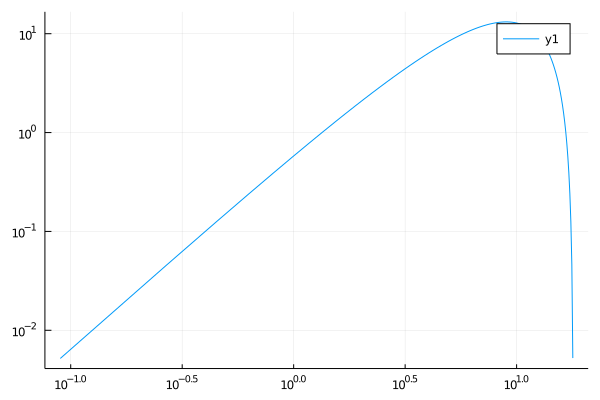

In [21]:
energy_list = (collect(1:num_plot_bar) .- (1 // 2)) * E_ν_max / num_plot_bar

flux_ν = [
    xx^2 * (M * (M - 2 * xx) - Mp^2)^2 / (M - 2 * xx)^2
    for xx ∈ energy_list
] * 1 / (8 * (2 * pi)^3) # see Appendix B

plot(energy_list,flux_ν,        xscale=:log10,yscale=:log10,)

In [22]:
flux_ν_max = max(flux_ν...)
single_weighted_sum = [zeros(num_plot_bar) for _ ∈ 1:Threads.nthreads()]

1-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [23]:
num_points=10^6

pg = Progress(num_points; desc="Evaluating ...")
counter = Threads.Atomic{Int}(0)
ProgressMeter.update!(pg, counter[])
Threads.@threads for _ ∈ 1:num_points
    ρn, pi_list = Φ(P, mass_list)
    p1, p2, p3 = pi_list

    @assert p3[1] ≤ E_ν_max
    energy_bar_indices = [
        (Int ∘ floor)(first(p_νbar) / E_ν_max * num_plot_bar) + 1
        for p_νbar ∈ [p3]
    ]

    amplitude_squared = amp_sq_8B_TO_8Be_e_νe(P, p2, p3)
    @assert amplitude_squared ≥ 0
    single_weighted_sum[Threads.threadid()][first(energy_bar_indices)] += ρn * amplitude_squared

    Threads.atomic_add!(counter, 1)
    ProgressMeter.update!(pg, counter[])
end

Evaluating ... 100%|█████████████████████████████████████| Time: 0:01:072:01


In [24]:
x = energy_list

## Single
y_νbar = sum(single_weighted_sum)  * prefactor / num_points
y_νbar /= (E_ν_max / num_plot_bar)


single_flux_νbar = copy(y_νbar)

100-element Array{Float64,1}:
 0.006856721062557169
 0.04738773934465185
 0.12294627220790309
 0.21879519561411764
 0.39885091507812714
 0.5775097281128243
 0.7482157410519756
 1.0507921934335682
 1.3294798637209424
 1.6403634260786193
 1.7917163139156966
 2.0863200727005338
 2.5496564579299177
 ⋮
 2.0978587229482155
 1.7088108302920502
 1.4982206986139825
 1.273812761340485
 1.016275923981013
 0.7984621300579674
 0.5826047378003191
 0.35738557915530433
 0.237464027720424
 0.12880469141018644
 0.05196940726920215
 0.006540698378839235

In [25]:
 CSV.write(
        "result/B8_standard.csv",
        DataFrame(
            "Energy"=>energy_list,
            "flux_ν_th"=>flux_ν,
            "flux_ν_MC" => single_flux_νbar
        )
    )

"result/B8_standard.csv"